In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt
import glob
from chainconsumer import ChainConsumer
import pickle
from ceffyl import Ceffyl, models
from enterprise.signals import parameter, gp_priors as gpp
from enterprise_extensions.model_utils import get_tspan
from natsort import natsorted
import la_forge.core as co
from la_forge.slices import SlicesCore

# ACCRE-specific import to load correct latex file
## COMMENT OUT AS REQUIRED
import os
os.environ["PATH"] += os.pathsep + '/home/lambwg/latex/bin/x86_64-linux' 

In [2]:
from astroML.stats import sigmaG  # rank-reduced uncertainty

In [250]:
plt.rcParams["figure.figsize"] = [3.5503666805036667*2, 2.1942472810764047]

# create a toy model

In [8]:
np.random.seed(25)

In [75]:
Tspan = 15 * 365.24 * 86400  # 15yr
Nfreqs = 30
freqs = np.arange(1, Nfreqs+1)/Tspan  # compute 30 freqs

##### one pulsar

In [35]:
# what is a typical value for log10rho?
log10_A, gamma = -14.7, 13/3
pl = gpp.powerlaw(freqs, log10_A=log10_A,
                  gamma=gamma, components=1)
log10_rho = 0.5*np.log10(pl)

In [36]:
print(log10_rho)

[-6.27750425 -6.9297359  -7.31126697 -7.58196756 -7.79193926 -7.96349862
 -8.10855    -8.23419922 -8.34502968 -8.44417091 -8.53385507 -8.61573028
 -8.69104818 -8.76078166 -8.82570198 -8.88643088 -8.94347691 -8.99726134
 -9.04813705 -9.09640257 -9.14231272 -9.18608672 -9.22791456 -9.26796194
 -9.30637427 -9.34327983 -9.3787924  -9.41301332 -9.44603324 -9.47793363]


add x% error to these values

In [138]:
err = 0.5

In [139]:
# assume log10rho are gaussian - sample from gaussian
X = np.log10(freqs).reshape(-1,1)
y = np.array([np.random.normal(lrho, err) for lrho in log10_rho])

ValueError: x and y must have same first dimension, but have shapes (30, 1) and (45, 30)

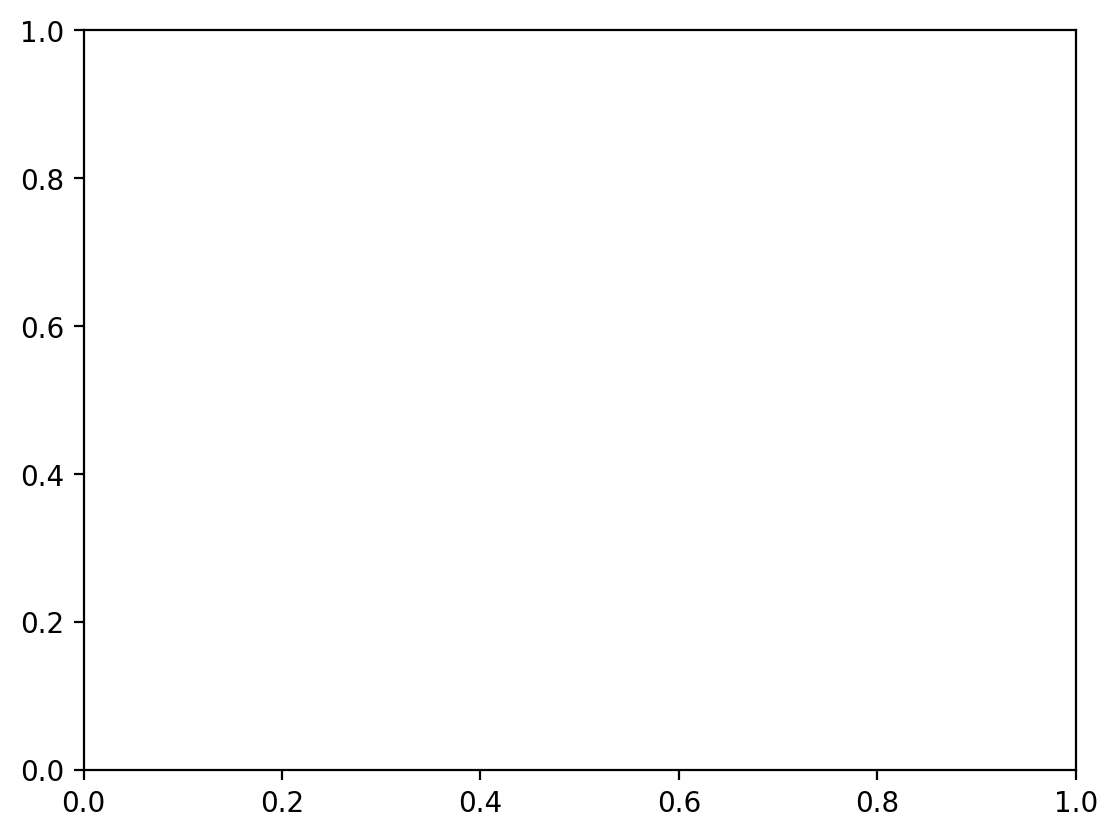

In [140]:
# plot what random data looks like
plt.plot(X, y, label='random')
plt.plot(X, log10_rho, label='real')
plt.legend()

linear regression!

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=err)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)
y_pred2 = lin_reg.predict(X)

In [141]:
y_pred2

array([[-6.36194018, -6.28826993, -6.15698451, ..., -6.291841  ,
        -6.29218425, -6.26856008],
       [-6.99265772, -6.93694982, -6.83424825, ..., -6.93366231,
        -6.9312448 , -6.92823599],
       [-7.36160383, -7.31640322, -7.23042214, ..., -7.30910371,
        -7.30507126, -7.31412166],
       ...,
       [-9.39402326, -9.40670437, -9.41283168, ..., -9.37730385,
        -9.36437514, -9.43985632],
       [-9.42595402, -9.43954449, -9.44711888, ..., -9.40979674,
        -9.39672826, -9.47325312],
       [-9.45680216, -9.47127116, -9.48024358, ..., -9.44118797,
        -9.42798446, -9.5055176 ]])

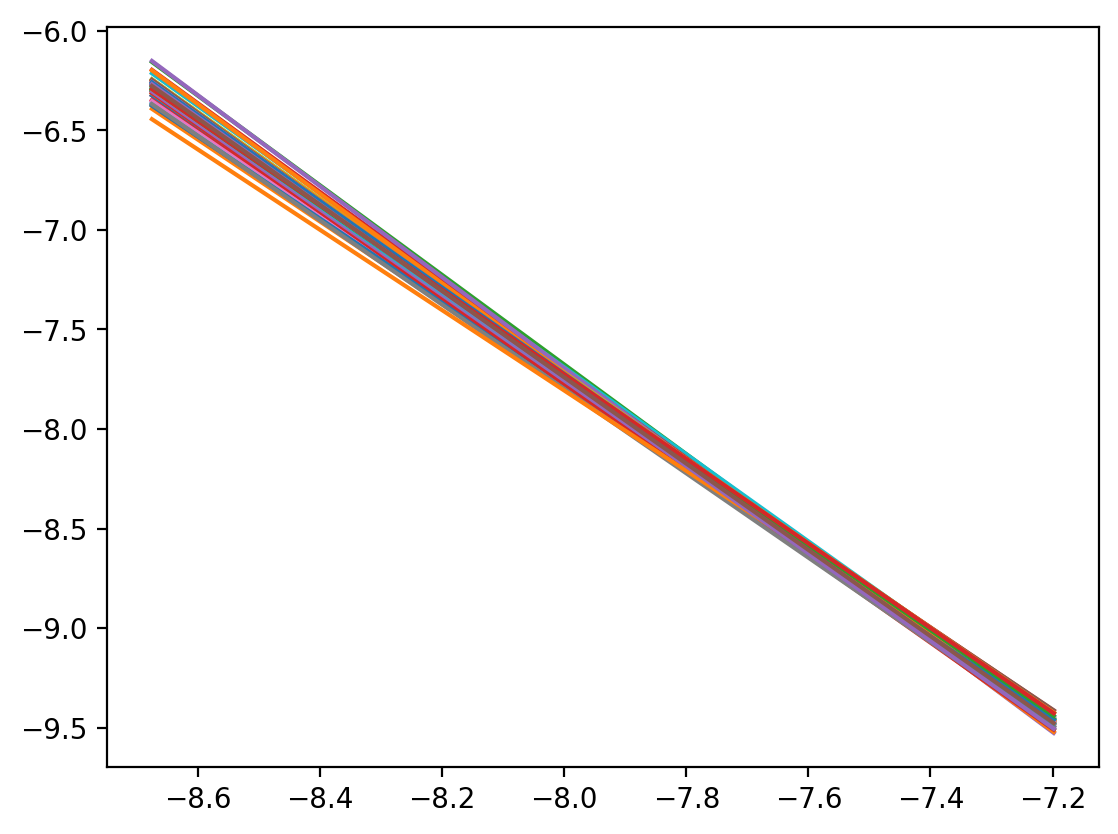

In [143]:
plt.plot(np.log10(freqs), y_pred2)
plt.plot(np.log10(freqs), log10_rho[0])

##### multiple pulsars

homoskedastic

In [173]:
Npsr, err = 45, 1

In [174]:
# what is a typical value for log10rho?
log10_A, gamma = -14.7, 13/3
pl = gpp.powerlaw(freqs, log10_A=log10_A,
                  gamma=gamma, components=1)
log10_rho = np.repeat(0.5*np.log10(pl)[None,:], repeats=[Npsr], axis=0)

In [175]:
# assume log10rho are gaussian - sample from gaussian
X = np.log10(freqs).reshape(-1,1)
y = np.array([[np.random.normal(log10_rho[npsr, nf], err)
               for nf in range(Nfreqs)] for npsr in range(Npsr)])

In [176]:
y.shape

(45, 30)

In [177]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y.T, sample_weight=None)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

y_pred2 = lin_reg.predict(X)

convert to $\gamma$, $\log_{10}\rho$

In [178]:
gamma_pred = - 2 * theta1.flatten()
log10A_pred = (theta0 +
               0.5*np.log10(12*np.pi**2*Tspan)
               - 0.5*(gamma_pred-3)*np.log10(1/(365.24*86400)))

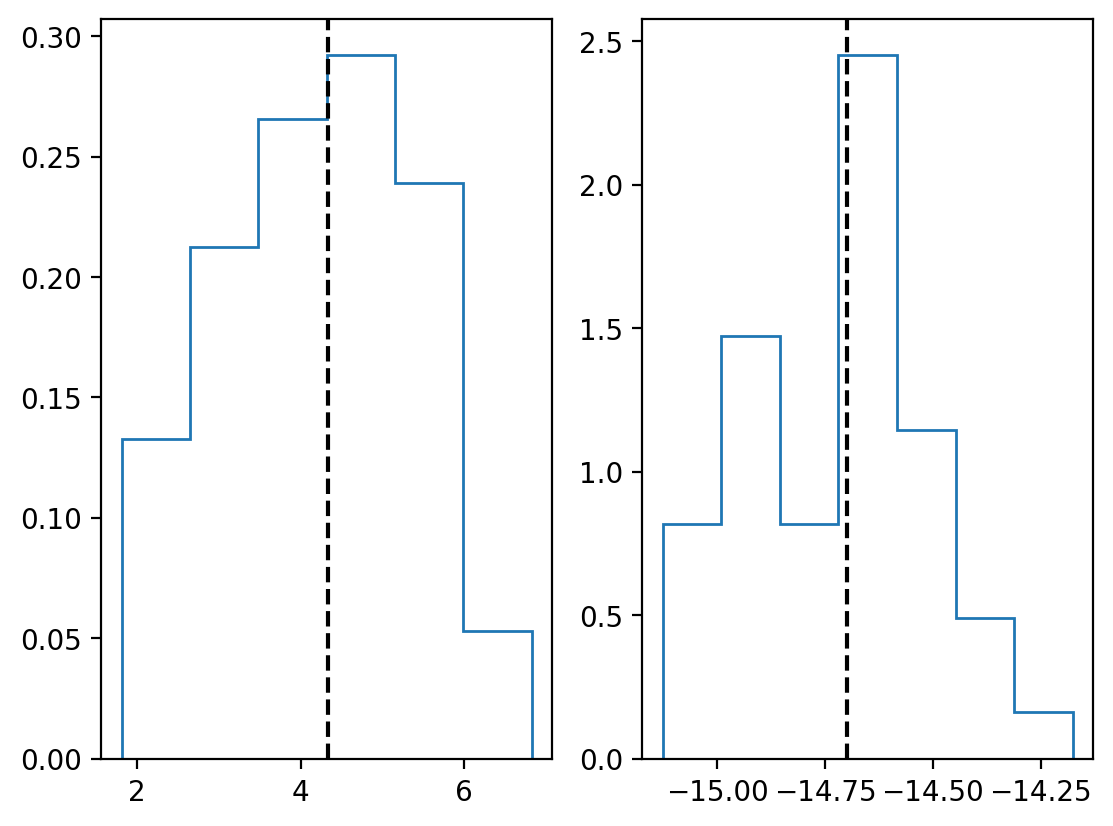

In [179]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.hist(gamma_pred, bins='fd', density=True,
         histtype='step')
ax2.hist(log10A_pred, bins='fd', density=True,
         histtype='step')

ax1.axvline(gamma, c='k', ls='--')
ax2.axvline(log10_A, c='k', ls='--');

In [166]:
def Neff(sigmas):
    """
    function to calculate neff from (Npsr x Nfreq)
    array of uncertainties
    """
    inv_sig2 = 1/sigmas**2
    sum_over_f = np.cumsum(inv_sig2, axis=1)
    Neff_f = sum_over_f.sum(axis=0)/sum_over_f.max(axis=0)
    
    for p in range(1, sum_over_f.shape[0]+1):
        n = sum_over_f[:p, -1]
        Neff_p = n.sum()/n.max()
        
    return Neff_f, Neff_p

In [167]:
sigmas = np.ones((45,10))*0.1
Neff(sigmas)

(array([45., 45., 45., 45., 45., 45., 45., 45., 45., 45.]), 45.0)

# To do

- make this into a function
- add heteroskedasticisity
- compute Neff given uncertainties
- what is sigmaG of recovered values in the end?

In [238]:
def Neff(sigmas):
    """
    function to calculate neff from (Npsr x Nfreq)
    array of uncertainties
    """
    inv_sig2 = 1/sigmas**2
    sum_over_f = np.cumsum(inv_sig2, axis=1)
    Neff_f = sum_over_f.sum(axis=0)/sum_over_f.max(axis=0)
    
    Neff_p = np.zeros(sigmas.shape[0])
    for p in range(1, sum_over_f.shape[0]+1):
        n = sum_over_f[:p, -1]
        Neff_p[p-1] = n.sum()/n.max()
        
    return Neff_f, Neff_p

In [357]:
from sklearn.linear_model import LinearRegression
def refit(Npsr, Nfreq, sigmas, Tspan=473351040,
          log10_A=-14.7, gamma=13/3, figs=True):
    """
    function to test fitting to toy models
    sigmas must be (Npsr x Nfreq) array
    """
    freqs = np.arange(1, Nfreq+1)/Tspan
    
    # what is a typical value for log10rho?
    pl = gpp.powerlaw(freqs, log10_A=log10_A,
                      gamma=gamma, components=1)
    log10_rho = np.repeat(0.5*np.log10(pl)[None,:],
                          repeats=[Npsr], axis=0)
    
    # assume log10rho are gaussian - sample from gaussian
    X = np.log10(freqs).reshape(-1,1)
    y = np.array([[np.random.normal(log10_rho[npsr, nf], sigmas[npsr, nf])
                   for nf in range(Nfreq)] for npsr in range(Npsr)])
    
    # run linear regression
    gamma_pred, log10A_pred = np.zeros((Npsr, Nfreq)), np.zeros((Npsr, Nfreq))
    for p in range(Npsr):
        for f in range(1, Nfreq+1):
            lin_reg = LinearRegression()
            lin_reg.fit(X[:f], y[p,:f], sample_weight=sigmas[p,:f])

            theta0 = lin_reg.intercept_
            theta1 = lin_reg.coef_

            #y_pred2 = lin_reg.predict(X)

            gamma_pred[p] = - 2 * theta1[0]
            log10A_pred[p] = (theta0 +
                              0.5*np.log10(12*np.pi**2*Tspan) -
                              0.5*(gamma_pred[p]-3) *
                              np.log10(1/(365.24*86400)))
        
    neff = Neff(sigmas)

    if figs:
        # ----------------------------------
        fig, (ax1, ax2) = plt.subplots(ncols=2)

        ax1.hist(gamma_pred, bins='fd', density=True,
                 histtype='step')
        ax2.hist(log10A_pred, bins='fd', density=True,
                 histtype='step')

        ax1.axvline(gamma, c='k', ls='--')
        ax2.axvline(log10_A, c='k', ls='--')

        ax1.set_xlabel('gamma')
        ax2.set_xlabel('log10 A')
        ax1.set_ylabel('density');
        plt.show();

        print(f'Median recovered gamma={np.median(gamma_pred)}')
        print(f'Median recovered log10A={np.median(log10A_pred)}')
        # -----------------------------------
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)

        ax1.plot(neff[0])
        ax2.plot(neff[1])

        ax1.set_xlabel('Nf')
        ax2.set_xlabel('Np')
        ax1.set_ylabel('Neff')
        #ax1.set_ylim(0);
    
    return gamma_pred, log10A_pred, neff

### homoskedastic case

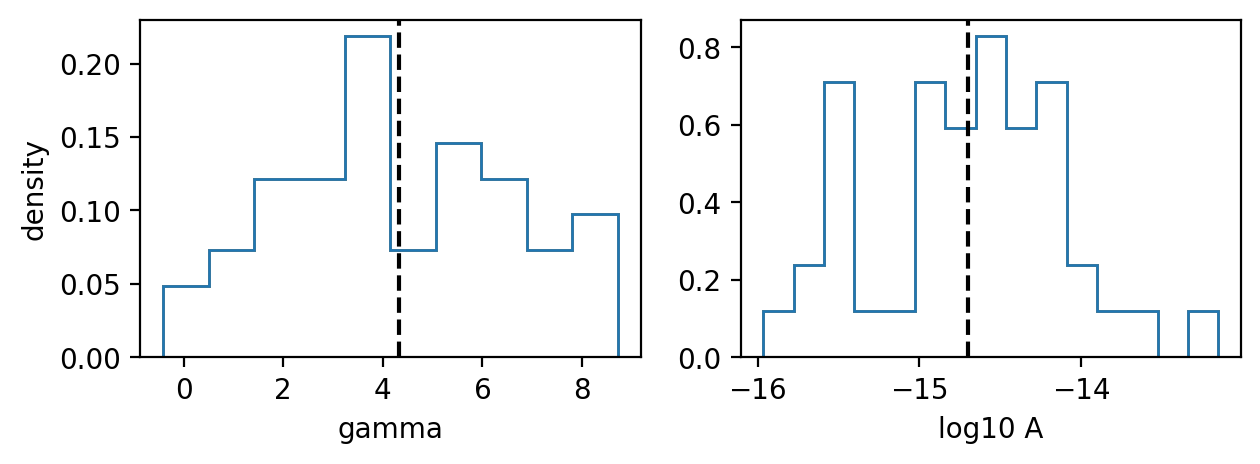

Median recovered gamma=4.074852335518622
Median recovered log10A=-14.648433407669152


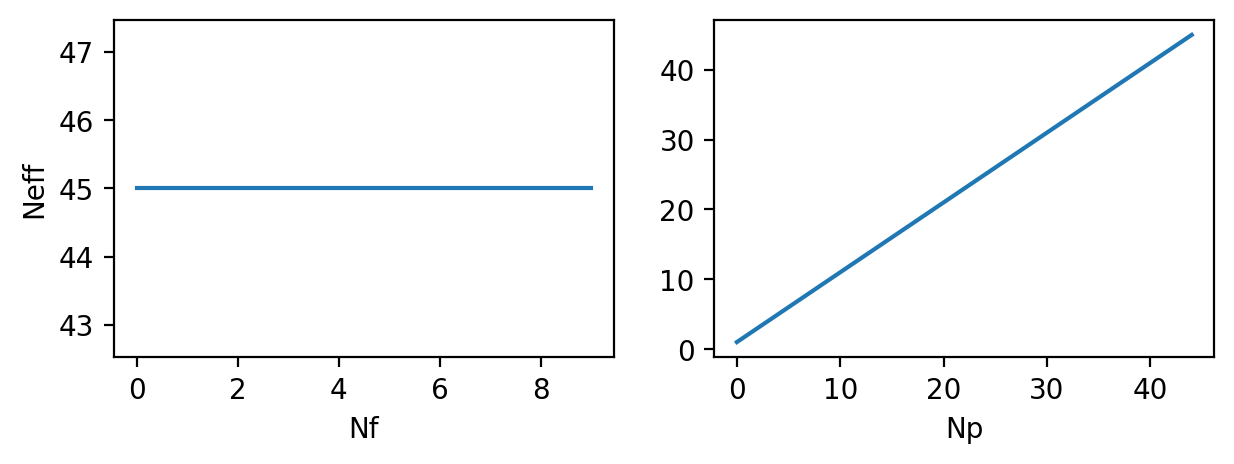

In [358]:
gpred, Apred, neff = refit(45, 10, np.ones((45, 10)))

### increasing uncertainty across freqs, all psrs same

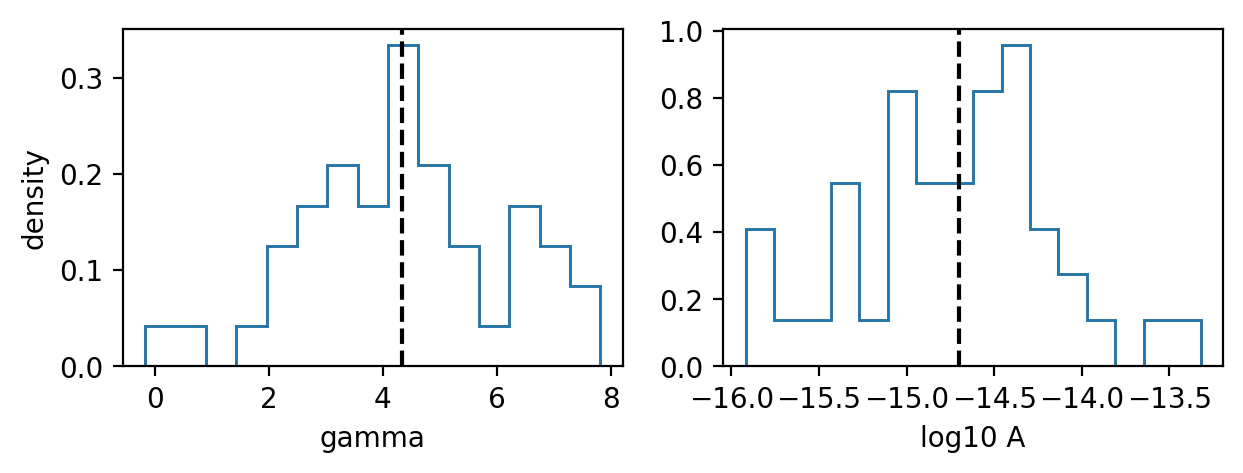

Median recovered gamma=4.213114522738763
Median recovered log10A=-14.706414565404327


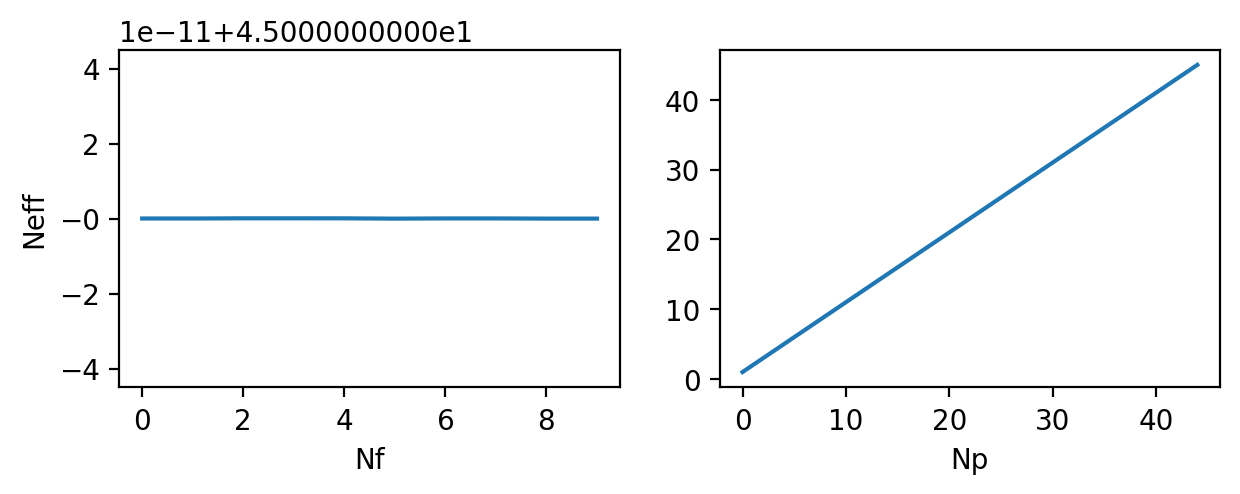

In [359]:
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(0.1, 1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

### decreasing uncertainty across freqs, all psrs same

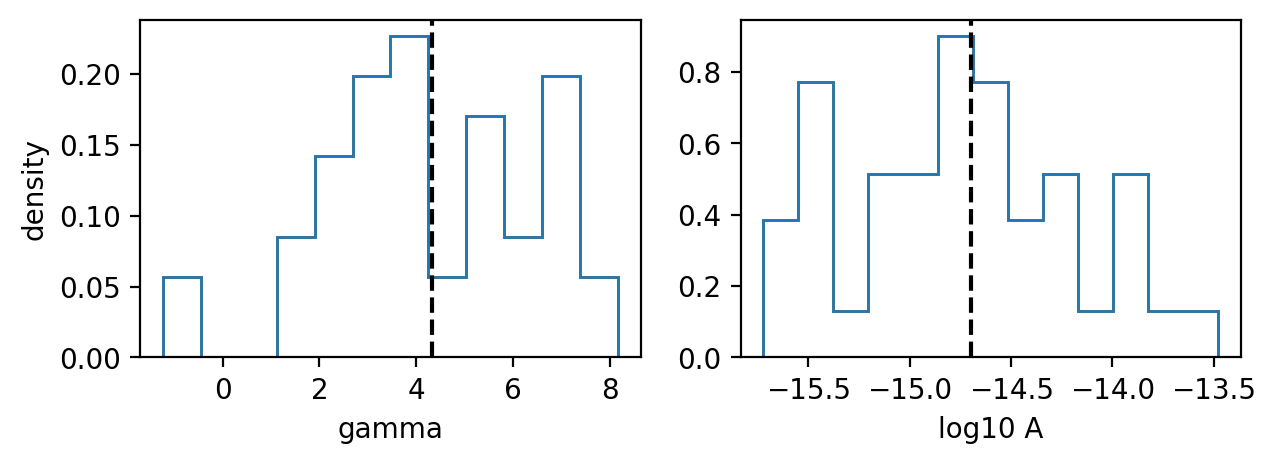

Median recovered gamma=4.0495100139330695
Median recovered log10A=-14.759706246881505


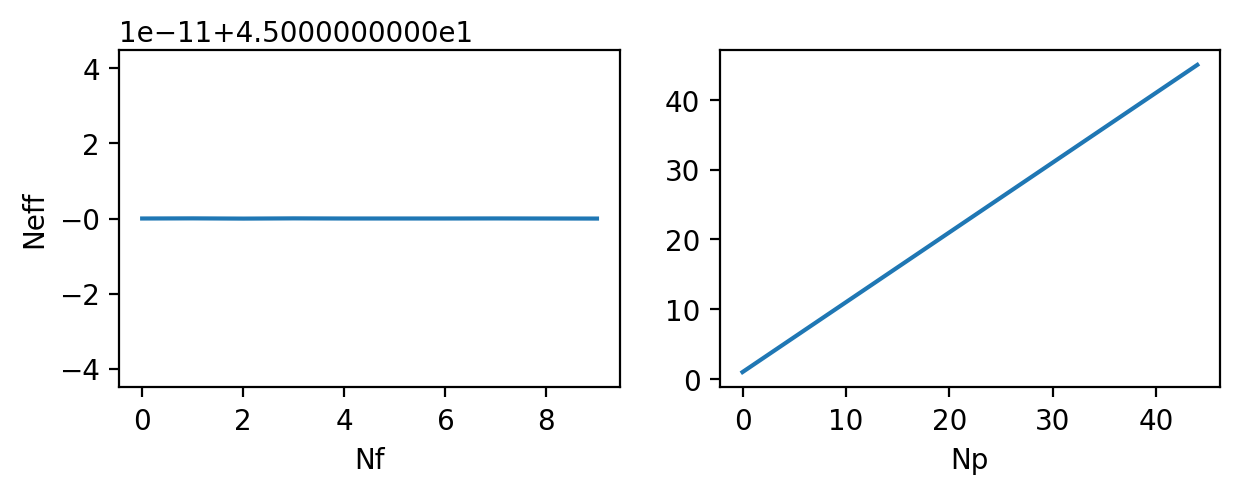

In [360]:
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(1, 0.1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

##### all pulsars equal uncertainty across freqs with one bad pulsar

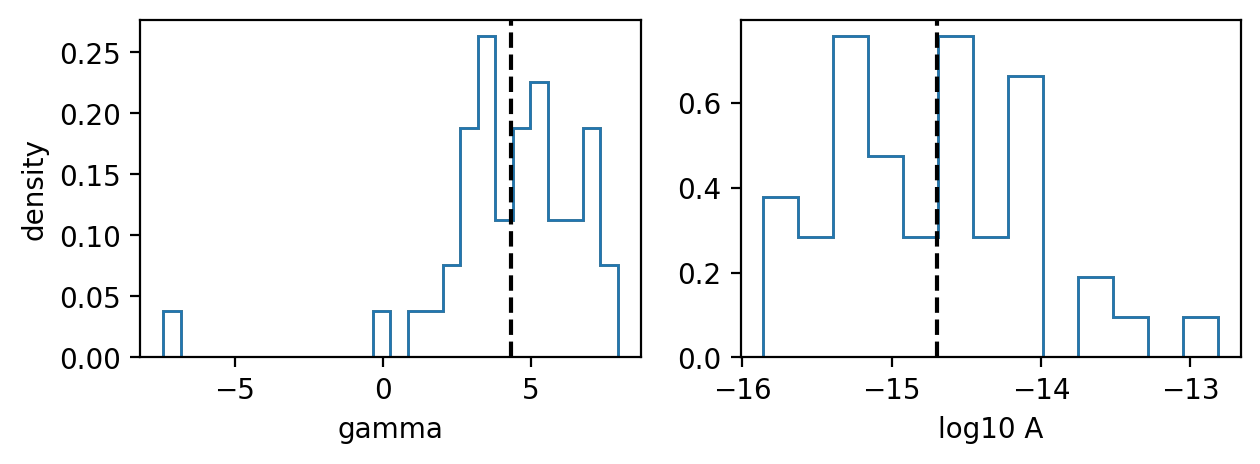

Median recovered gamma=4.635970860834186
Median recovered log10A=-14.707257774198013


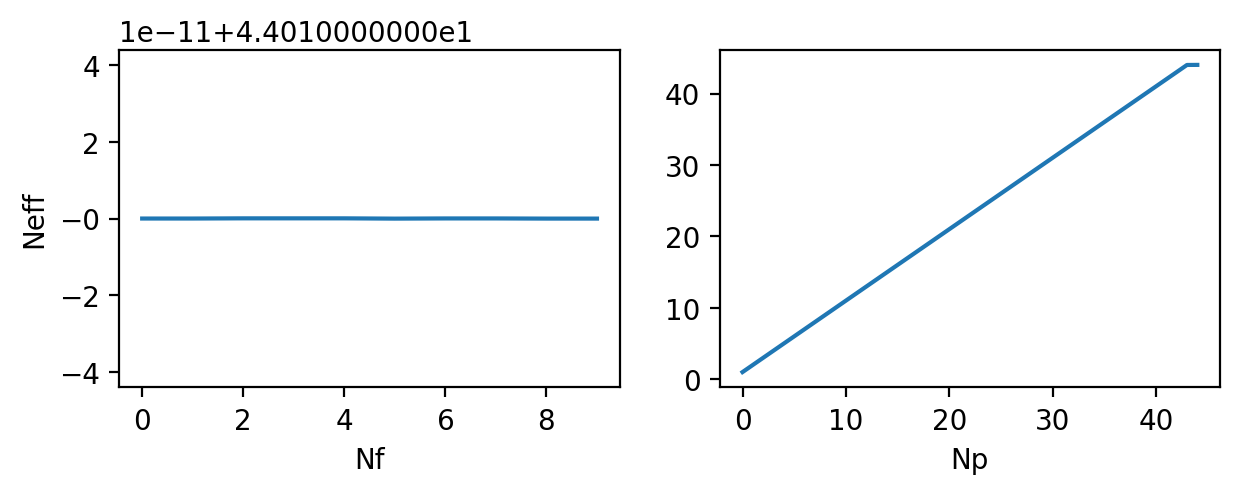

In [363]:
# final pulsar bad
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(0.1, 1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
sigmas[-1]*=10
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

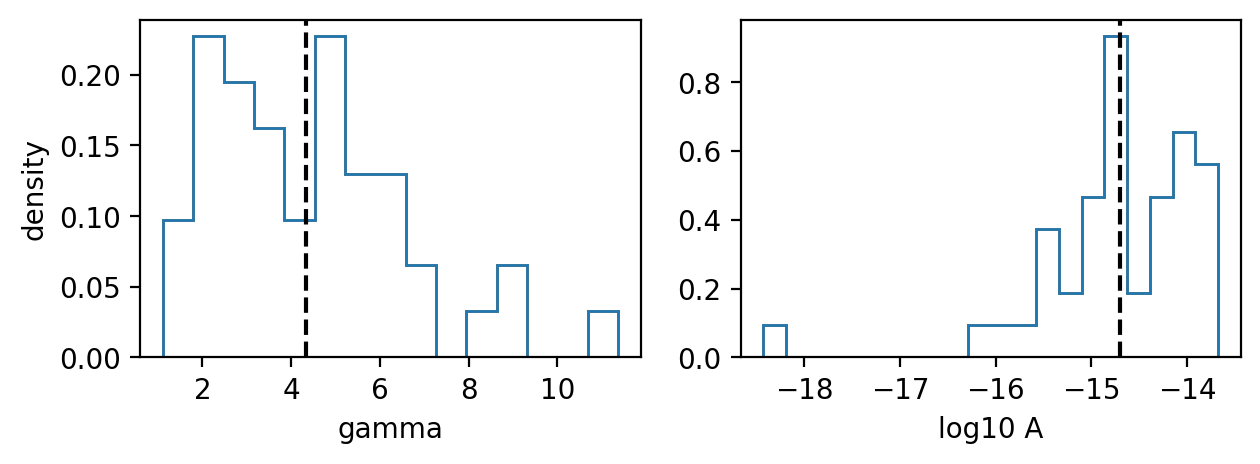

Median recovered gamma=3.9667852093063054
Median recovered log10A=-14.723343256777348


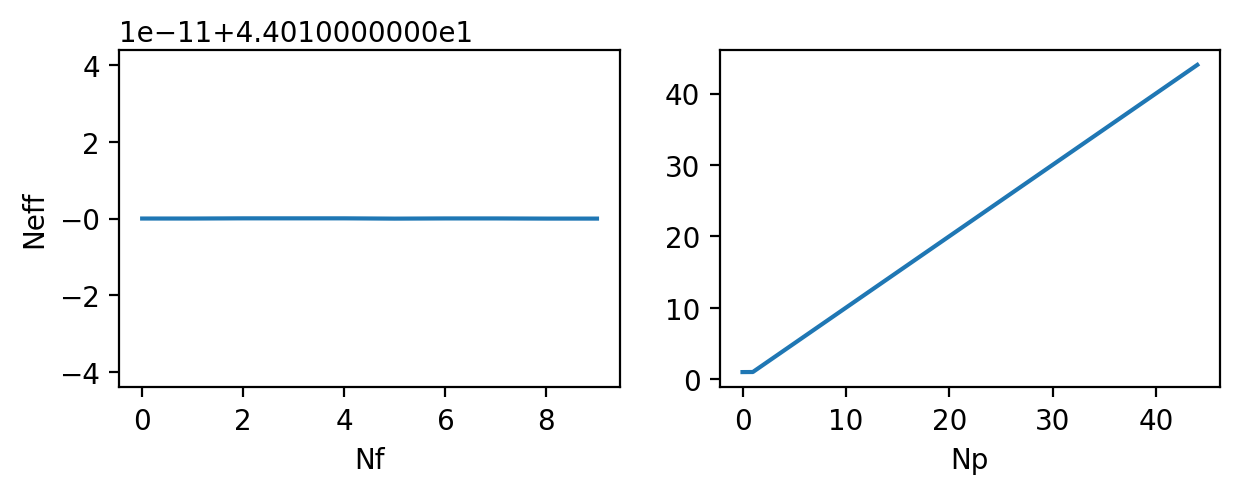

In [364]:
# first pulsar bad
# final pulsar bad
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(0.1, 1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
sigmas[0]*=10
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

##### one psr very good

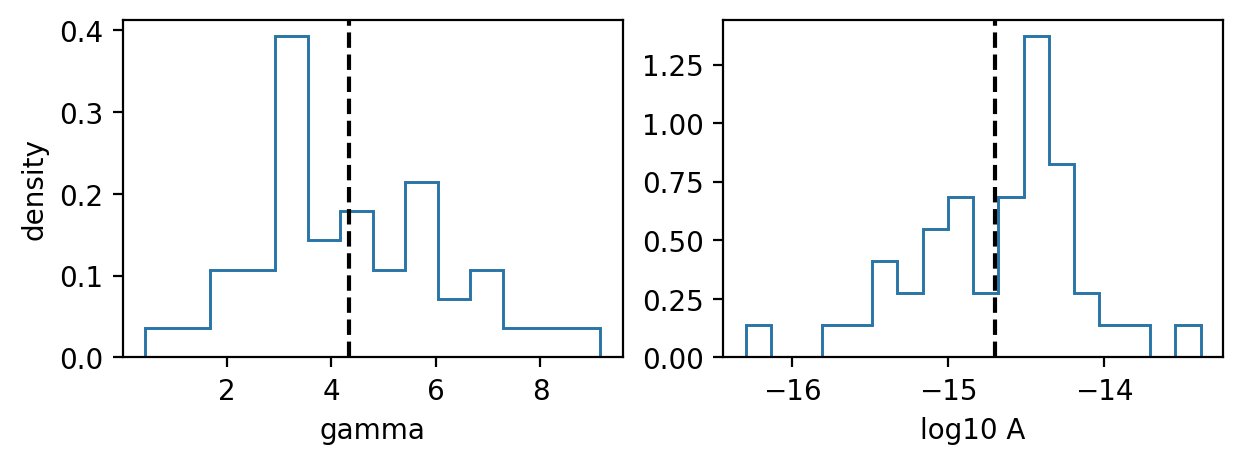

Median recovered gamma=4.144964233485102
Median recovered log10A=-14.62331195961394


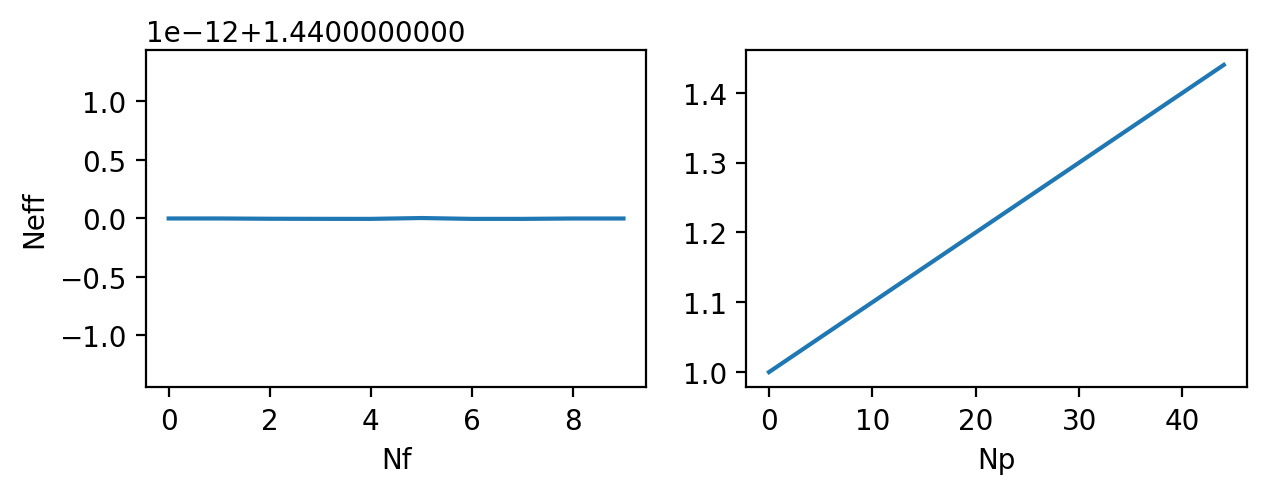

In [372]:
# first pulsar good
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(0.1, 1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
sigmas[0]/=10
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

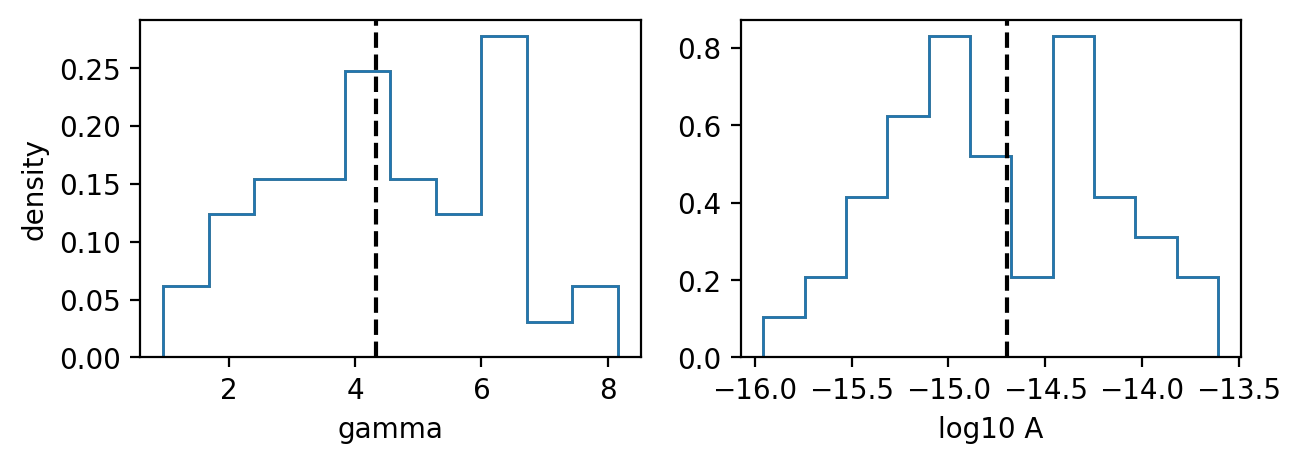

Median recovered gamma=4.304244525224181
Median recovered log10A=-14.794259419835539


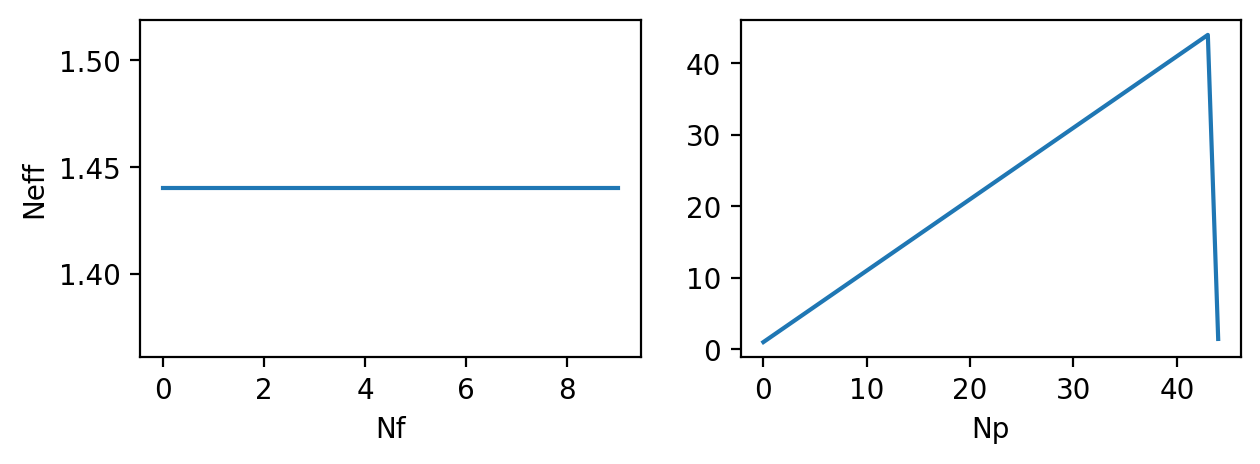

In [373]:
# final pulsar good
Npsr, Nfreq = 45, 10
sigmas = np.repeat(np.linspace(0.1, 1, Nfreq)[None,:],
                   repeats=[Npsr], axis=0)
sigmas[-1]/=10
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

### just random

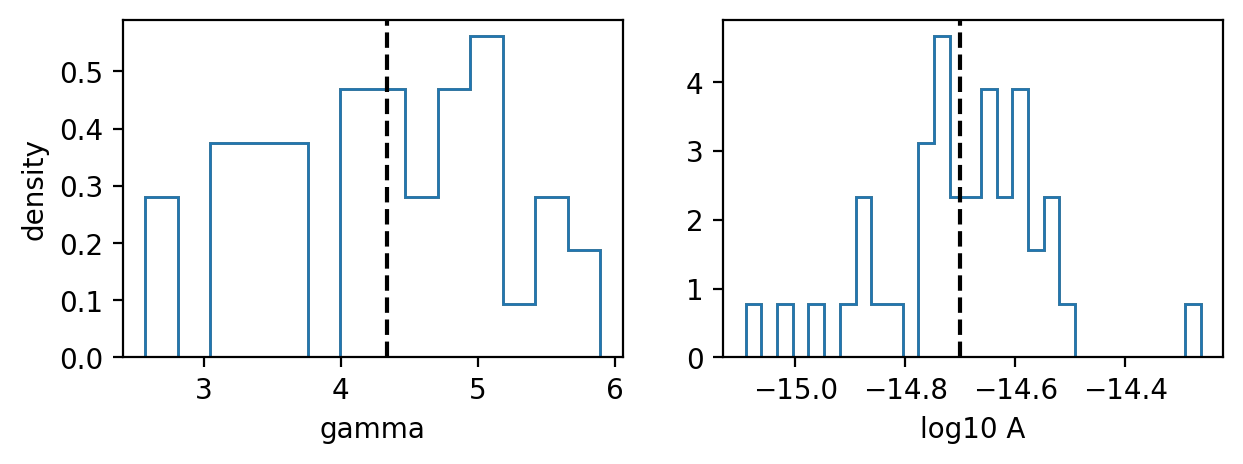

Median recovered gamma=4.312612625020092
Median recovered log10A=-14.686354339298333


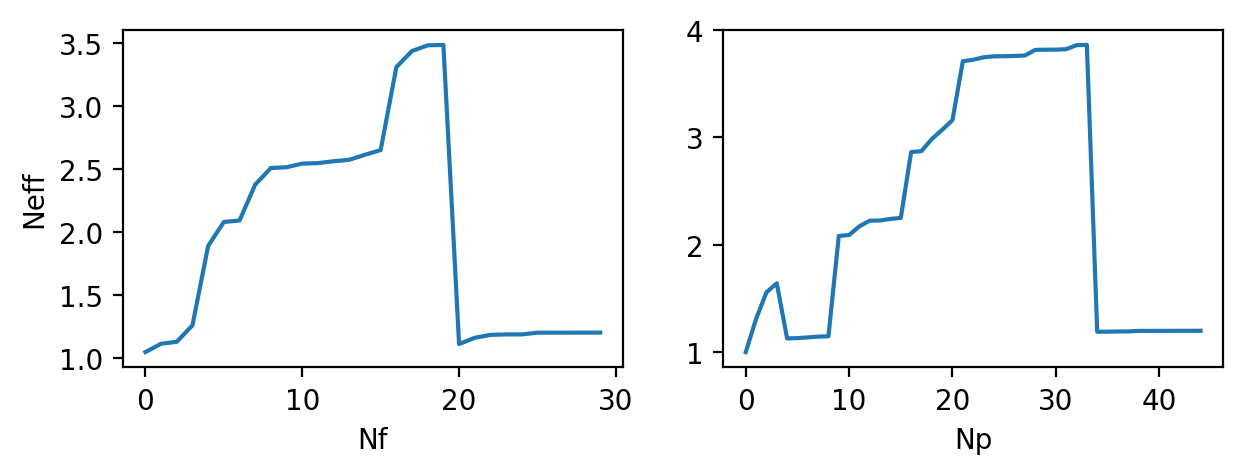

In [374]:
Npsr, Nfreq = 45, 30
sigmas = np.random.rand(Npsr, Nfreq)
gpred, Apred, neff = refit(Npsr, Nfreq, sigmas)

In [375]:
Npsr, Nfreq, iters = 45, 10, 1000
Neff_range = np.zeros((iters, 45))
for ii in range(iters):
    sigmas = np.random.rand(Npsr, Nfreq)
    _, _, neff = refit(Npsr, Nfreq,
                       sigmas, figs=False)
    Neff_range[ii] = neff[1]

In [376]:
Neff_range.shape

(1000, 45)

In [377]:
np.median(Neff_range, axis=0)

array([1.        , 1.16960634, 1.31970217, 1.39390559, 1.47094441,
       1.48537897, 1.50886541, 1.52420254, 1.51498402, 1.53661716,
       1.56561334, 1.57190347, 1.56263594, 1.57275967, 1.5682801 ,
       1.58050448, 1.59823149, 1.61047065, 1.6129258 , 1.61688806,
       1.60141528, 1.60815652, 1.60840048, 1.5909302 , 1.56529831,
       1.59309565, 1.59293409, 1.58808768, 1.58474644, 1.58306469,
       1.58713281, 1.57505387, 1.5713908 , 1.55586788, 1.54165926,
       1.56124165, 1.54359157, 1.55875857, 1.56774551, 1.57885671,
       1.5780812 , 1.5805026 , 1.59323708, 1.59069093, 1.59737516])

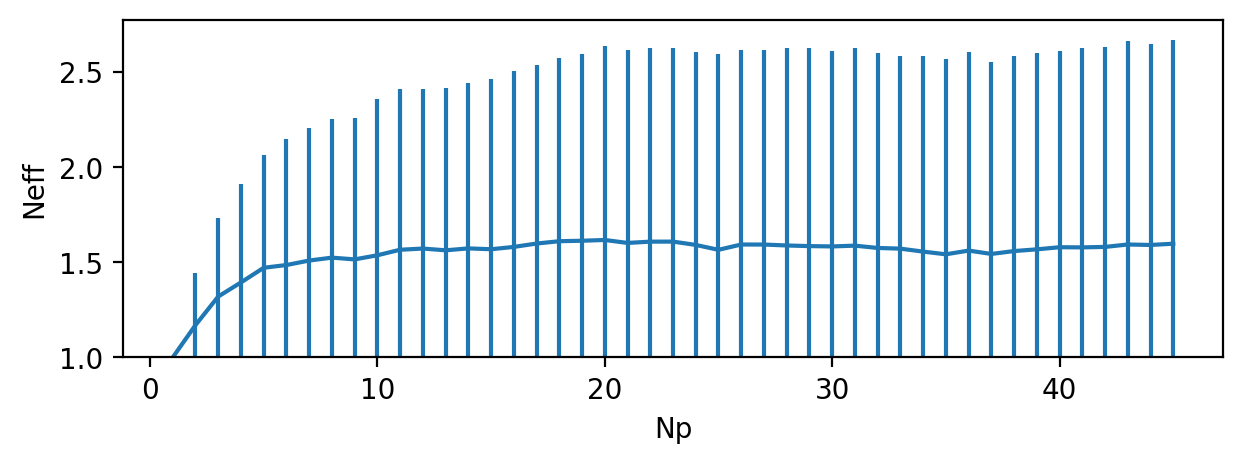

In [378]:
p = np.arange(1, 46)
Neff_p_med = np.median(Neff_range, axis=0)
Neff_p_err = np.std(Neff_range, axis=0)

plt.plot(p, Neff_p_med)
plt.errorbar(p, Neff_p_med, Neff_p_err,
             fmt=' ', c='C0')
plt.ylim(1)
plt.xlabel('Np')
plt.ylabel('Neff');